## K-Means Clustering for High School Report Card in Chicago 2024

In [71]:
import matplotlib.pyplot as plt
import numpy
import pandas
import sys

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)

from sklearn.cluster import KMeans
from sklearn.metrics import (calinski_harabasz_score, davies_bouldin_score, silhouette_score)
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score

# Set some options for printing all the columns
numpy.set_printoptions(precision = 10, threshold = sys.maxsize)
numpy.set_printoptions(linewidth = numpy.inf)

pandas.set_option('display.max_columns', None)
pandas.set_option('display.expand_frame_repr', False)
pandas.set_option('max_colwidth', None)

pandas.options.display.float_format = '{:,.10f}'.format

In [73]:
input_df = pandas.read_csv('/Users/olivia/Downloads/ML - Assignment 1/IL_HS_ReportCard_2024_SelectedColumns.csv')
input_df.iloc[:, [9, 10]] = (input_df.iloc[:, [9, 10]] - 200) / 6

# Partition analysis data into Training (70%) and Testing (30%) partitions
#X_name = ['% ELA Proficiency','% Math Proficiency','% Science Proficiency','SAT Reading Average Score','SAT Math Average Score','SAT ELA Proficiency Rate - Total']
X_name = input_df.iloc[:, 6:12]
y_name = input_df.iloc[:, 5] 
X_train, X_test, y_train, y_test = train_test_split(
    X_name,y_name, train_size=0.7, random_state=202531017)

def elbow_value (X, cluster_member, cluster_centroid):
   n_cluster = cluster_centroid.shape[0]
   WCSS = [0.0] * n_cluster
   cluster_count = [0.0] * n_cluster
   irow = 0
   for index, row in X.iterrows():
      k = cluster_member[irow]
      diff = row - cluster_centroid[k]
      WCSS[k] += diff.dot(diff)
      cluster_count[k] += 1.0
      irow += 1

   elbow = 0.0
   for k in range(n_cluster):
      if (cluster_count[k] > 0.0):
         elbow += WCSS[k] / cluster_count[k]

   return (elbow)

# Determine the most appealing number of neighbors
k_choice = range(2,21,1)
result_list = []
for k in k_choice:
    model_obj = KMeans(n_clusters = k, init = 'random', n_init = 'auto', random_state = 202531017)
    model_train = model_obj.fit(X_train)

    elbow_train = elbow_value(X_train, model_train.labels_, model_train.cluster_centers_)
    silhouette_train =  silhouette_score(X_train, model_train.labels_)
    ch_train = calinski_harabasz_score(X_train, model_train.labels_)
    db_train = davies_bouldin_score(X_train, model_train.labels_)

    test_labels = model_train.predict(X_test)
    elbow_test = elbow_value(X_test, test_labels, model_train.cluster_centers_)   
    silhouette_test =  silhouette_score(X_test, test_labels)
    ch_test = calinski_harabasz_score(X_test, test_labels)
    db_test = davies_bouldin_score(X_test, test_labels)

    result_list.append([k, elbow_train, elbow_test, silhouette_train, silhouette_test, \
                        ch_train, ch_test, db_train, db_test])

choice_df = pandas.DataFrame(result_list, columns = ['N Clusters','Elbow Train','Elbow Test', \
                                                     'Silhouette Train','Silhouette Test',
                                                     'CH Train', 'CH Test', 'DB Train','DB Test'])

#### a) Please provide a line plot of the Elbow Value versus the number of clusters, a separate line, marker, and color per partition.  Proper labeling is required to obtain full credits.  What optimal number of clusters will you suggest based on this line plot?  Please justify your suggestion.

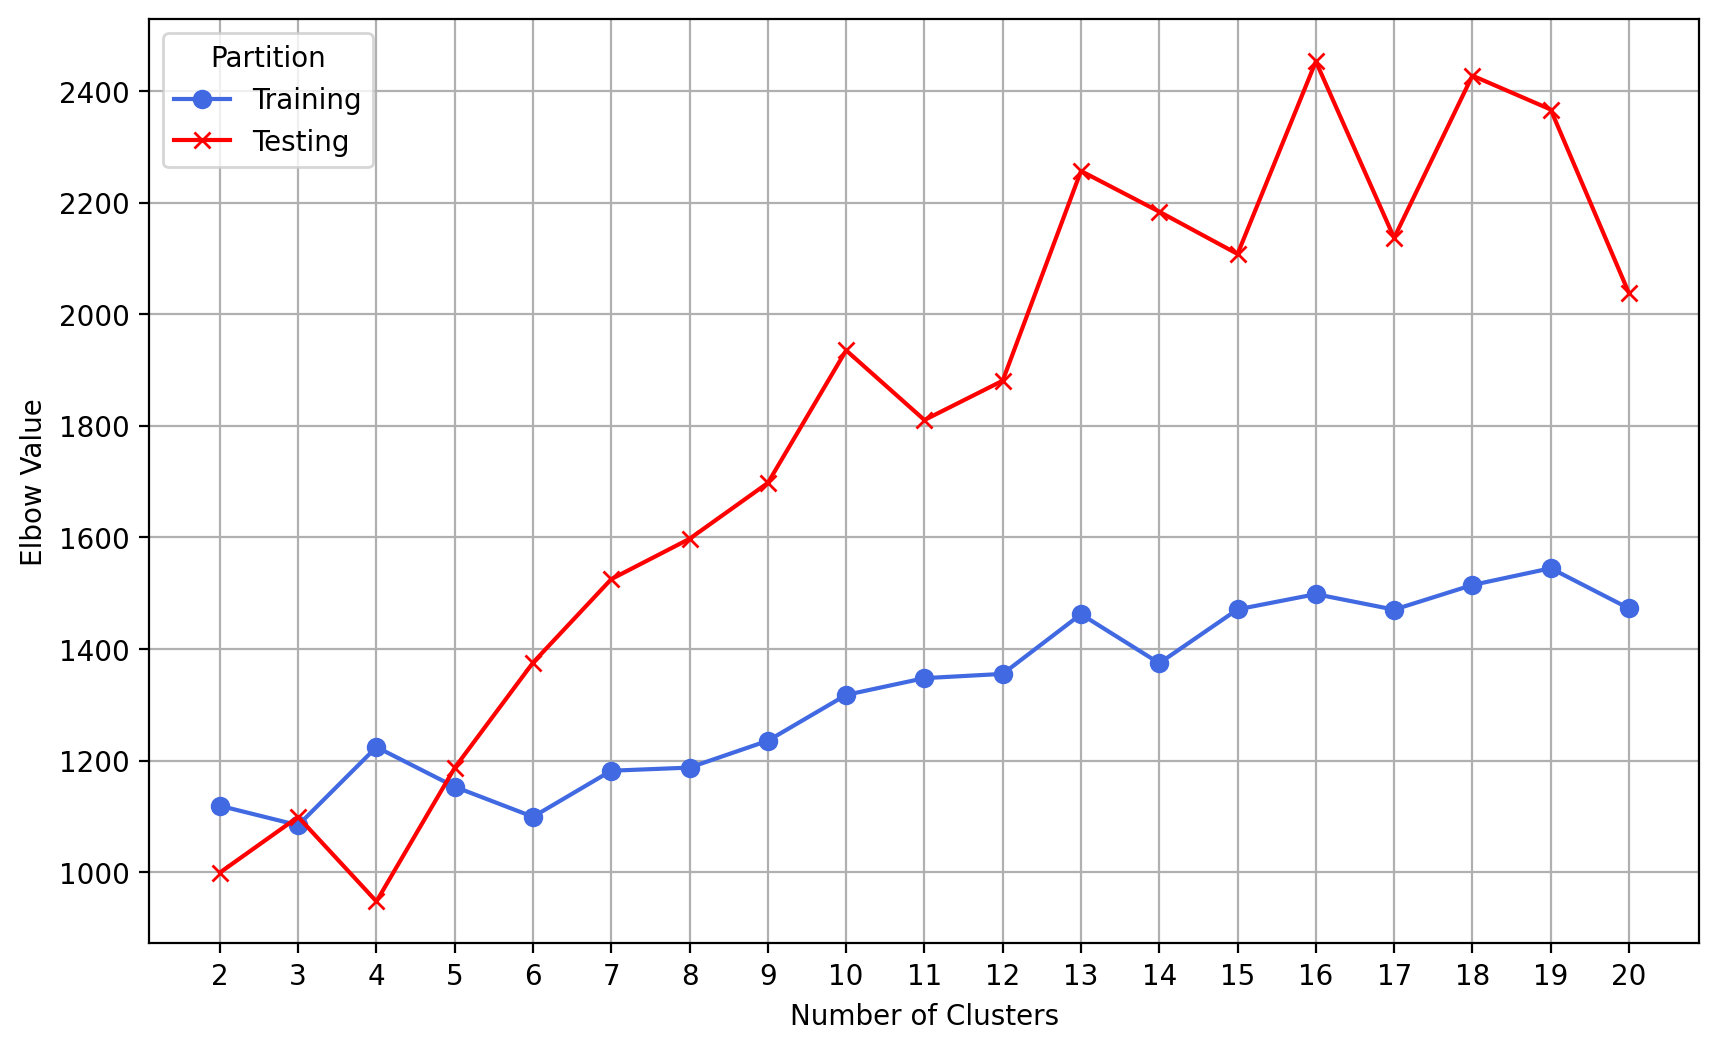

In [75]:
plt.figure(figsize = (10,6), dpi = 200)
plt.plot(choice_df['N Clusters'], choice_df['Elbow Train'], marker = 'o', color = 'royalblue', label = 'Training')
plt.plot(choice_df['N Clusters'], choice_df['Elbow Test'], marker = 'x', color = 'red', label = 'Testing')
plt.xlabel('Number of Clusters')
plt.ylabel('Elbow Value')
plt.xticks(k_choice)
plt.grid(axis = 'both')
plt.legend(title = 'Partition')
plt.show()

*In the plot above, cluster 3,4,5 seems to be the right one since this is where the drop in the elbow value slows down, which means if we add more clusters it will not reduce the value much. The training curve is smooth, but the testing curve changes a lot, meaning higher clusters may not be stable. But among 3,4,5, cluster 3 seems to be the best one, since its stabilizing for both training and testing data*

#### b) Please provide a line plot of the Silhouette Score versus the number of clusters, a separate line, marker, and color per partition.  Proper labeling is required to obtain full credits.  What optimal number of clusters will you suggest based on this line plot?  Please justify your suggestion.

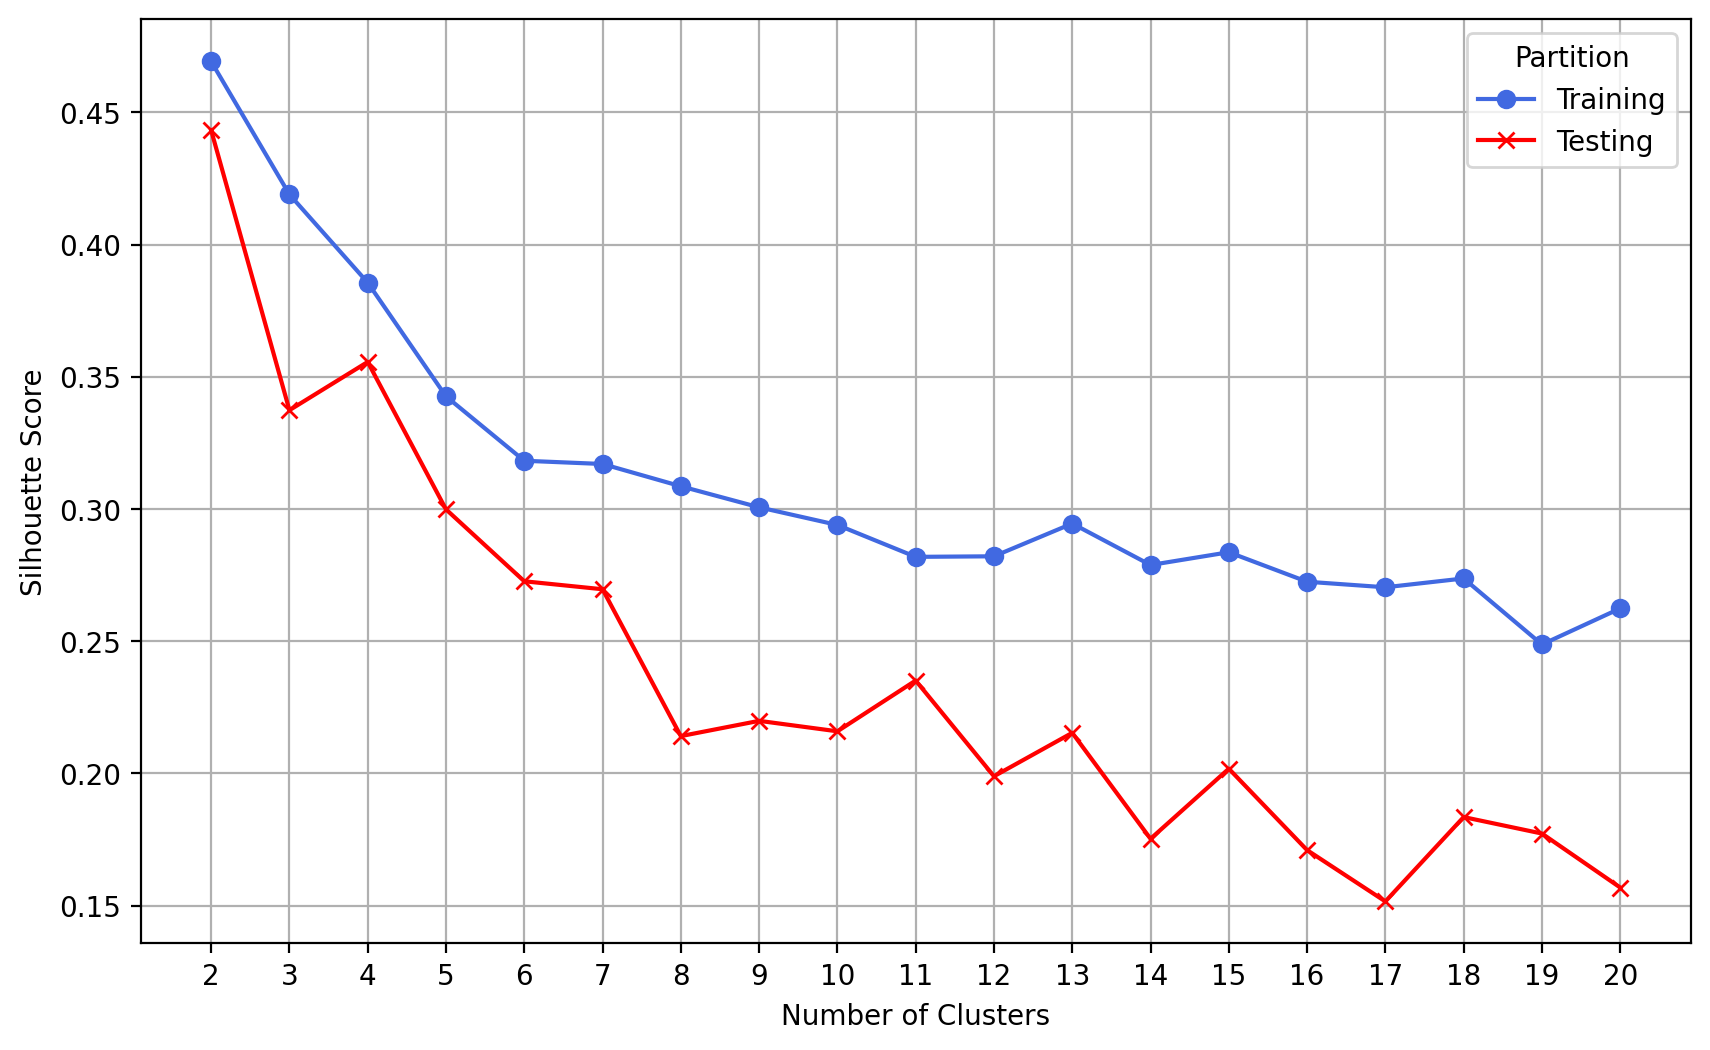

In [78]:
plt.figure(figsize = (10,6), dpi = 200)
plt.plot(choice_df['N Clusters'], choice_df['Silhouette Train'], marker = 'o', color = 'royalblue', label = 'Training')
plt.plot(choice_df['N Clusters'], choice_df['Silhouette Test'], marker = 'x', color = 'red', label = 'Testing')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(k_choice)
plt.grid(axis = 'both')
plt.legend(title = 'Partition')
plt.show()

*Higher silhouette is better, so the best cluster seems like at 2,3,4 clusters, but the scores go down as the number of the clusters increases. After 4 clusters, the scores drop a lot, which may means that the clusters are less clear, especially in the testing data. This, the best one according to sillhouette value is 4.*

#### c) After consolidating Parts (a) and (b), what is your final suggestion?  Since we want to uncover clusters among the 435 high schools, you will retrain the K-Means Clustering algorithm using your final suggestion on the entire data of 435 high schools.  What is the Elbow Value and the Silhouette Score of this model?

*From result in part (a) and (b), we need to choose cluster that bring balance between these two score, so **4 clusters will be the final suggestion**. Because it is where the elbow method shows stability, and the silhouette score is still decent. Otherwise, if we choose only 2 or 3 clusters may be too simple, while more than 5 clusters do not add much value.*

In [82]:
# Identify the number of clusters that yields the largest Silhouette value
#result_df = choice_df.sort_values(by = ['Silhouette Test'], ascending = False)
#k = result_df.iloc[0]['N Clusters'].astype(int)
k=4

# Cluster the entire dataset
model_obj = KMeans(n_clusters = k, init = 'random', n_init = 'auto', random_state = 202531017)
model_train = model_obj.fit(X_name)

# Membership counts
member_series = pandas.Series(model_train.labels_, name = '_Member_', index = input_df.index)

elbow_final = elbow_value(X_name, model_train.labels_, model_train.cluster_centers_)
print("Elbow Value:", elbow_final)
silhouette_final = silhouette_score(X_name, model_train.labels_)
print("Silhouette Score:", silhouette_final)

Elbow Value: 1150.2794638636337
Silhouette Score: 0.37359210701259515


#### d)	What are the cluster centroids?  Also, what are the mean values of $ Total Per-Pupil Expenditures – Subtotal and # School Enrollment in the clusters?  Do you find any evidence that high schools with high-performing students also invested more resources in students?  Do you think the enrollment numbers matter?

In [88]:
# Centroids in original scale
#centroid_df = pandas.DataFrame(model_train.cluster_centers_, columns = X_name)
centroid_df = pandas.DataFrame(model_train.cluster_centers_, columns=X_name.columns)

input_df['_Cluster_'] = model_train.labels_

mean_values = input_df.groupby('_Cluster_')[['$ Total Per-Pupil Expenditures - Subtotal', '# School Enrollment']].mean()
mean_values

,$ Total Per-Pupil Expenditures - Subtotal,# School Enrollment
_Cluster_,,
0,"17,351.8114166667","1,142.8278333333"
1,"21,824.2379411765","2,152.8673529412"
2,"17,156.3982539683",919.1960317460
3,"18,956.2195652174","1,361.0307608696"


**Do you find any evidence that high schools with high-performing students also invested more resources in students?**

From the result above, Cluster 1 spends the most per student at around $21,824 and has the largest number of students at around 2,152. If this cluster includes high-scoring students, it suggests that schools that spend more per student may have better academic results.

Meanwhile, Clusters 0, 2, and 3 spend less per student which are only around $17,000–$19,000 and have fewer students. If these clusters have lower scores, this means less spending might lead to lower student performance.

**Do you think the enrollment numbers matter?**

Cluster 1 has the most students at around 2,152 and the highest spending per student, while Cluster 2 has the fewest students at around 919 and the lowest spending. This means that, although larger schools get more funding, they still spend a lot per student. However, if we talk in the context of academic equality, having too many students may can reduce teacher attention and lower their performance. 

Let's say, if the best schools are in smaller clusters, it might mean smaller schools provide a better learning environment with more personalized attention for their student. But if the top schools are in bigger clusters, then funding and resource allocation may be more important than school size. In that case, as long as schools invest enough per student, even large schools can maintain high academic performance.

#### e)	Do the nearest neighbors of Jones College Prep High School belong to the same cluster?  What about those nearest neighbors of Rich Township High School?  Do these two high schools belong to different clusters?  Are you surprised by the findings?

In [92]:
jones_cluster = input_df[input_df['School Name'] == 'Jones College Prep High School']['_Cluster_'].values[0]
rich_cluster = input_df[input_df['School Name'] == 'Rich Township High School']['_Cluster_'].values[0]

print(f"Jones College Prep is in Cluster {jones_cluster}")
print(f"Rich Township High School is in Cluster {rich_cluster}")

nearest_jones = input_df[input_df['_Cluster_'] == jones_cluster][['School Name', '_Cluster_']].head(10)
nearest_rich = input_df[input_df['_Cluster_'] == rich_cluster][['School Name', '_Cluster_']].head(10)

print("Nearest neighbors of Jones College Prep:")
print(nearest_jones)

print("Nearest neighbors of Rich Township High School:")
print(nearest_rich)


Jones College Prep is in Cluster 1
Rich Township High School is in Cluster 3
Nearest neighbors of Jones College Prep:
                          School Name  _Cluster_
35    New Trier Township H S Winnetka          1
37            Maine South High School          1
40               Wm Fremd High School          1
45            John Hersey High School          1
46               Prospect High School          1
52        Glenbrook North High School          1
53        Glenbrook South High School          1
54   Oak Park & River Forest High Sch          1
57                 Lyons Twp High Sch          1
142        Lane Technical High School          1
Nearest neighbors of Rich Township High School:
                        School Name  _Cluster_
3                 Unity High School          3
5      Beardstown Jr/Sr High School          3
22            Belvidere High School          3
27        Rockford East High School          3
28             Guilford High School          3
29           

On the calculation and the result, we only focus on the top 10 closest to Jones College Prep High School and Rich Township High School.

Jones College Prep High School is in Cluster 1, and all its nearest schools are in the same cluster. This means they likely have high student performance and good funding. Rich Township High School is in Cluster 3, and its nearest schools are also in the same cluster, this suggest that they have similar resources and academic results. 

Since Jones College Prep is a selective school and Rich Township serves more general students, it makes more sense that they are in different clusters because schools with similar performance and funding are grouped, which reflects the differences in school resources and student achievement. I am not that surprised but also wonder if we have more info, we may can explore based on income level and see if the cluster reflect some economic status.